# Task 3 Classification
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*

## Version with MINIMAL set of features

## Importing Libraries
First we import libraries necessary to classify the data

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, balanced_accuracy_score, classification_report
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv("../dataset/user_indicators_uncorrelated.csv") 

In [3]:
dict_colors_bot = { 1: 'teal', 0: 'sandybrown'}

In [4]:
# Functions that prints the classification report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['non-bot', 'bot']))

## Dataset cleaning and preprocessing

Convert total success score to log scale

In [5]:
df.total_success_score = np.log(df.total_success_score + 1)

AttributeError: 'DataFrame' object has no attribute 'total_success_score'

Show ratio of bot/not-bot labels in the dataset

Int64Index([1, 0], dtype='int64')


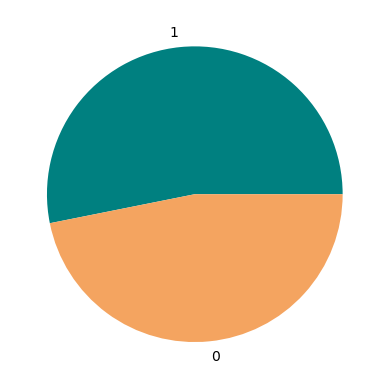

1    6116
0    5392
Name: bot, dtype: int64


In [ ]:
bot_value_count = df['bot'].value_counts()
print(bot_value_count.keys())
# Show pie plot
labels = ['non-bot', 'bot']
plt.pie(bot_value_count, labels= bot_value_count.index, colors=[dict_colors_bot[v] for v in bot_value_count.keys()])
plt.show()
print(bot_value_count)

### Extract labels and data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           11508 non-null  int64  
 1   lang                              11508 non-null  object 
 2   bot                               11508 non-null  int64  
 3   created_at                        11508 non-null  object 
 4   statuses_count                    11508 non-null  int64  
 5   tweet_count                       11508 non-null  int64  
 6   avg_text_len                      11508 non-null  float64
 7   entropy_minute                    11508 non-null  float64
 8   entropy_day                       11508 non-null  float64
 9   post_in_2012                      11508 non-null  int64  
 10  post_in_2013                      11508 non-null  int64  
 11  post_in_2014                      11508 non-null  int64  
 12  post

Exclude some user specific features that are not useful or no to be used in classifcation

In [125]:
y = df['bot'].to_numpy()

del df['user_id']
del df['created_at']
del df['bot']
del df['post_in_2012']
del df['post_in_2013']
del df['post_in_2014']
del df['post_in_2015']
del df['post_in_2016']
del df['post_in_2017']
del df['post_in_2018']
del df['post_in_2019']
del df['post_in_2020']
del df['years_outside_of_plausible_range']
del df['creation_year']
del df['reply_count_avg']
del df['favorite_count_avg']
del df['num_hashtags_avg']
del df['num_urls_avg']
del df['num_mentions_avg']
del df['retweet_count_sum']
del df['favorite_count_sum']

X = df.to_numpy()

The following features are used for this version of classification.

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   statuses_count      11508 non-null  float64
 1   tweet_count         11508 non-null  int64  
 2   avg_text_len        11508 non-null  float64
 3   entropy_minute      11508 non-null  float64
 4   entropy_day         11508 non-null  float64
 5   reply_count_avg     11508 non-null  float64
 6   favorite_count_avg  11508 non-null  float64
 7   num_hashtags_avg    11508 non-null  float64
 8   num_urls_avg        11508 non-null  float64
 9   num_mentions_avg    11508 non-null  float64
 10  retweet_count_sum   11508 non-null  float64
 11  favorite_count_sum  11508 non-null  float64
 12  lang_ar             11508 non-null  uint8  
 13  lang_da             11508 non-null  uint8  
 14  lang_de             11508 non-null  uint8  
 15  lang_el             11508 non-null  uint8  
 16  lang

### Train Test split

We split the dataset in training, validation and test sets (70/15/15 split). Combining training and validation set, we also defined a development set (85% of data), as some models do not require validation.

In [127]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=15, test_size=0.15, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=15, test_size=0.18, stratify=y_dev)

In [128]:
print('Development set size:', len(y_dev), '- Bot ratio:', round(np.count_nonzero(y_dev)/len(y_dev), 2))
print('     Train set size:', len(y_train), '- Bot ratio:', round(np.count_nonzero(y_train)/len(y_train), 2))
print('     Validation set size:', len(y_val), '- Bot ratio:', round(np.count_nonzero(y_val)/len(y_val), 2))
print('Test set size:', len(y_test), '- Bot ratio:', round(np.count_nonzero(y_test)/len(y_test), 2))

Development set size: 9781 - Bot ratio: 0.53
     Train set size: 8020 - Bot ratio: 0.53
     Validation set size: 1761 - Bot ratio: 0.53
Test set size: 1727 - Bot ratio: 0.53


### Normalization  
A good practice in classification to avoid the bias given by the range of the different attribute is normalization. We used z-score normalization.

In [129]:
scaler = StandardScaler()
X_std_dev = scaler.fit_transform(X_dev)
X_std_train = scaler.fit_transform(X_train)
X_std_val = scaler.fit_transform(X_val)
X_std_test = scaler.fit_transform(X_test)

## KNN

In [130]:
from sklearn.neighbors import KNeighborsClassifier

We try different values for K and evaluate their performance on validation.

In [131]:
k_list = [x for x in range(1, 20)]
knn_list = []
acc_tr_list = []
acc_val_list = []


for k in tqdm(k_list):
    # Create knn model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_std_train, y_train)
    knn_list.append(knn)
    # Predict for train and validation sets
    y_pred_train = knn.predict(X_std_train)
    y_pred_val = knn.predict(X_std_val)
    # Accuracy
    acc_tr = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_tr_list.append(acc_tr)
    acc_val_list.append(acc_val)

100%|██████████| 19/19 [01:07<00:00,  3.56s/it]


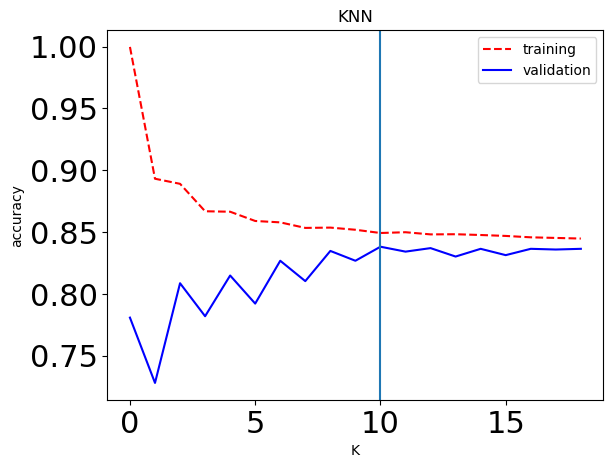

In [132]:
plt.plot(range(len(acc_tr_list)), acc_tr_list, 'r--', label='training')
plt.plot(range(len(acc_val_list)), acc_val_list, 'b-',  label='validation')
plt.ylabel('accuracy')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('KNN')
plt.axvline(10)
plt.legend(loc="upper right")
plt.show()

We select K=10, as it is the smaller K where the model does not fall into overfitting.

Now let's see in more depth the scores on validation and test.

In [133]:
knn = knn_list[9]

y_pred_val = knn.predict(X_std_val)
print('## Validation:')
report_scores(y_val, y_pred_val)

y_pred_test = knn.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Validation:
              precision    recall  f1-score   support

     non-bot       0.89      0.72      0.80       825
         bot       0.79      0.92      0.85       936

    accuracy                           0.83      1761
   macro avg       0.84      0.82      0.82      1761
weighted avg       0.84      0.83      0.82      1761

## Test:
              precision    recall  f1-score   support

     non-bot       0.86      0.73      0.79       809
         bot       0.79      0.90      0.84       918

    accuracy                           0.82      1727
   macro avg       0.83      0.82      0.82      1727
weighted avg       0.83      0.82      0.82      1727



Performances on test is very similar to validation. We have slightly lower recall for non-bots (0.73), meaning that there are a signinficant number of bots classified as 0.

## Bayesian classifier

In [134]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB 

Both Gaussian and Bernoulli Bayesian classifier are tested on validation.

In [161]:
gnb = GaussianNB()

y_pred_val = gnb.fit(X_std_train, y_train).predict(X_std_val)
print('## Validation:')
report_scores(y_val, y_pred_val)

## Validation:
              precision    recall  f1-score   support

     non-bot       0.51      1.00      0.67       825
         bot       1.00      0.14      0.24       936

    accuracy                           0.54      1761
   macro avg       0.75      0.57      0.46      1761
weighted avg       0.77      0.54      0.44      1761



In [163]:
bnb = BernoulliNB()

y_pred_val = bnb.fit(X_std_train, y_train).predict(X_std_val)
print('## Validation:')
report_scores(y_val, y_pred_val)

## Validation:
              precision    recall  f1-score   support

     non-bot       0.79      0.66      0.72       825
         bot       0.74      0.85      0.79       936

    accuracy                           0.76      1761
   macro avg       0.76      0.75      0.75      1761
weighted avg       0.76      0.76      0.75      1761



Only the Bernoulli Naive Bayes achieves satisfactory scores on valoidation, while Gaussian Naive Bayes fails to classify correctly, having an accuracy only slightly over 0.5. So we only test on test set Bernoulli after retrain on the whole development set.

In [164]:
bnb = BernoulliNB()


y_pred_test = bnb.fit(X_std_dev, y_dev).predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.80      0.66      0.72       809
         bot       0.74      0.86      0.80       918

    accuracy                           0.76      1727
   macro avg       0.77      0.76      0.76      1727
weighted avg       0.77      0.76      0.76      1727



Bernoulli Naive Bayes instead reaches decent accuracy but still lower than the others models.

## Decision Tree

In [137]:
from sklearn.tree import DecisionTreeClassifier

In [138]:
# Function that finds the best decision tree doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_decision_tree(X, y, cv=6, print_res=True):
    params = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4]
    }] 
    clf = GridSearchCV(DecisionTreeClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("DT - Best parameters set found:")
        print(clf.best_params_)
        print("DT - Best accuraccy score found:")
        print(clf.best_score_)
    
    return(clf.best_score_, clf.best_estimator_)

Get the best decision tree doing Cross Validation on the entire development set.

In [139]:
best_score_dt, best_dt = build_decision_tree(X_std_dev, y_dev)

Fitting 6 folds for each of 108 candidates, totalling 648 fits
DT - Best parameters set found:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6}
DT - Best accuraccy score found:
0.8420404007728582


Test the best DT

In [140]:
y_pred_test = best_dt.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.94      0.72      0.81       809
         bot       0.79      0.96      0.87       918

    accuracy                           0.84      1727
   macro avg       0.87      0.84      0.84      1727
weighted avg       0.86      0.84      0.84      1727



Performances on test are the same as the CV score of the best model, so we don't have overfitting at all. Again, we have slightly lower recall for non-bots (0.72), meaning that there are a signinficant number of bots classified as 0.

## Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [142]:
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_random_forest(X, y, cv=6, print_res=True):
    params = [{
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64, 128]
    }] 
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("RF - Best parameters set found:")
        print(clf.best_params_)
        print("RF - Best accuraccy score found:")
        print(clf.best_score_)
    
    return(clf.best_score_, clf.best_estimator_)

Get the best Random Forest model doing Cross Validation on the entire development set.

In [143]:
best_score_rf, best_rf = build_random_forest(X_std_dev, y_dev)

Fitting 6 folds for each of 54 candidates, totalling 324 fits
RF - Best parameters set found:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 128}
RF - Best accuraccy score found:
0.8518553486325149


In [144]:
print("RF - Best accuraccy score found:")
print(best_score_rf)

RF - Best accuraccy score found:
0.8518553486325149


Test the best RF model.

In [145]:
y_pred_test = best_rf.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.96      0.72      0.82       809
         bot       0.80      0.97      0.88       918

    accuracy                           0.85      1727
   macro avg       0.88      0.85      0.85      1727
weighted avg       0.87      0.85      0.85      1727



Performances on test are the same as the CV score of the best model, so we don't have overfitting at all. Again, we have slightly lower recall for non-bots (0.72), meaning that there are a signinficant number of bots classified as 0.

## SVM

In [146]:
from sklearn import svm

In [147]:
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_SVM(X, y, cv=6, print_res=True):
    params = [
    {"kernel": ["rbf", "linear", "sigmoid"], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100]},
    {"kernel": ["poly"], "degree": [2,3,4], "gamma": ["scale", "auto"], "C": [0.1, 1, 10, 100]},

    ] 
    clf = GridSearchCV(svm.SVC(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("SVM - Best parameters set found:")
        print(clf.best_params_)
        print("SVM - Best accuracy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

Get the best SVM doing Cross Validation on the entire development set.

In [148]:
best_score_svm, best_svm = build_SVM(X_std_dev, y_dev)

Fitting 6 folds for each of 72 candidates, totalling 432 fits
SVM - Best parameters set found:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM - Best accuracy score found:
0.8446982605675567


Test the best SVM

In [149]:
y_pred_test = best_svm.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

     non-bot       0.95      0.70      0.80       809
         bot       0.78      0.97      0.87       918

    accuracy                           0.84      1727
   macro avg       0.87      0.83      0.84      1727
weighted avg       0.86      0.84      0.84      1727



Performances on test are slightly higher then the CV score of the best model, so we don't have overfitting at all. Again, we have slightly lower recall for non-bots (0.70), meaning that there are a signinficant number of bots classified as 0.

## MLP

In [150]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks

In [151]:
# Function that builds a NN from a list configuration containing layer neurons
def build_nn(layers_config):
    model = Sequential()

    for i, layer_neurons in enumerate(layers_config):
        # Add hidden layers with the current number of neurons
        if i==0: # First layer
            model.add(Dense(layer_neurons, activation='relu', input_dim=X_std_train.shape[1]))
        else:
            model.add(Dropout(.2))
            model.add(Dense(layer_neurons, activation='relu', input_dim=layers_config[i-1]))
    
    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Build, train and test on validation all the configurations for the MLP.

In [152]:
# Define a list of possible lists of numbers of neurons for each layer
layers_config_list = [[32, 16], [16, 8], [20], [12], [48, 16], [64, 24, 6]]

history_list = []
models_list = []
val_acc_list = []

# Iterate over all possible combinations of number of layers and neurons
for layers_config in layers_config_list:
    # Builds NN architecture
    model = build_nn(layers_config)

    # Add early stopping that checks val loss
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                    mode ="min", patience = 3, 
                                    restore_best_weights = True)
    
    # Train the model on the training set
    history = model.fit(X_std_train, y_train, validation_data = (X_std_val,y_val),
        epochs=40, batch_size=32, verbose=0, callbacks=[earlystopping])
    
    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_std_val, y_val, verbose=0)

    # Save and show results
    print('NN with ', layers_config, 'configuration - Validation Score:', accuracy,
        '- Epochs:', earlystopping.stopped_epoch)
    history_list.append(history)
    models_list.append(model)
    val_acc_list.append(accuracy)

NN with  [48, 16] configuration - Validation Score: 0.8438387513160706 - Epochs: 12
NN with  [24, 12] configuration - Validation Score: 0.8449744582176208 - Epochs: 26
NN with  [24] configuration - Validation Score: 0.8461101651191711 - Epochs: 19
NN with  [12] configuration - Validation Score: 0.8415672779083252 - Epochs: 27
NN with  [48, 24] configuration - Validation Score: 0.8466780185699463 - Epochs: 17
NN with  [64, 24, 6] configuration - Validation Score: 0.8483815789222717 - Epochs: 20


The best NN is the one with 3 hidden layers (64, 24 and 6 neurons each), which reaches the highest validation accuracy.

In [153]:
best_nn_index = 5

best_history = history_list[best_nn_index]
best_nn = models_list[best_nn_index]

Training curves of best NN

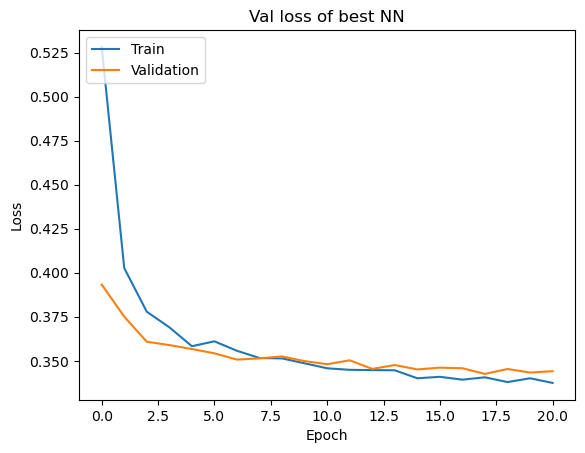

In [154]:
plt.plot(best_history.history['loss']) 
plt.plot(best_history.history['val_loss']) 
plt.title('Val loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

Retrain on whole development set

In [173]:
# Builds NN architecture
model = build_nn(layers_config_list[best_nn_index])

# Train the model on the whole development set
final_history = model.fit(X_std_dev, y_dev, validation_data = (X_std_test, y_test), epochs=24, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred_test = np.rint(model.predict(X_std_test, verbose=0))

Retraining + test curves

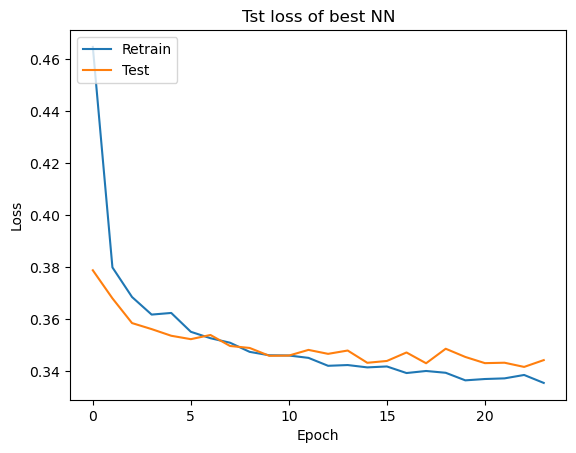

In [174]:
plt.plot(final_history.history['loss']) 
plt.plot(final_history.history['val_loss']) 
plt.title('Tst loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Retrain', 'Test'], loc='upper left') 
plt.show()

Show test results

In [176]:
print('NN with ', layers_config, 'configuration')
report_scores(y_test, y_pred_test)

NN with  [64, 24, 6] configuration
              precision    recall  f1-score   support

     non-bot       0.97      0.70      0.81       809
         bot       0.79      0.98      0.87       918

    accuracy                           0.85      1727
   macro avg       0.88      0.84      0.84      1727
weighted avg       0.87      0.85      0.84      1727



## Conclusions

Overall, the best models on test set are the MLP and Random Forest, altough with much simpler models such as Decision Tree and even K-NN we get comparable accuracies.